In [21]:
import numpy as np
import pandas as pd

In [22]:
races_df = pd.read_csv('races.csv', index_col='race_id')
runs_df = pd.read_csv('runs.csv')

# Data Preprocessing

create new dataframe df that we will use to train the model

### Remove unnessussary columns from runs_df

In [23]:
df = runs_df
df=df.drop('won',axis=1)
df=df.drop('horse_gear',axis=1)
df=df.drop('draw',axis=1)
df = df.drop('horse_no', axis = 1)

# the below have too many na values
df=df.drop('position_sec1',axis=1)
df=df.drop('position_sec2',axis=1)
df=df.drop('position_sec3',axis=1)
df=df.drop('position_sec4',axis=1)
df=df.drop('position_sec5',axis=1)
df=df.drop('position_sec6',axis=1)
df=df.drop('behind_sec1',axis=1)
df=df.drop('behind_sec2',axis=1)
df=df.drop('behind_sec3',axis=1)
df=df.drop('behind_sec4',axis=1)
df=df.drop('behind_sec5',axis=1)
df=df.drop('behind_sec6',axis=1)
df=df.drop('time4',axis=1)
df=df.drop('time5',axis=1)
df=df.drop('time6',axis=1)
df=df.drop('place_odds',axis=1) 

### Add relevant columns from races_df

In [24]:
df = pd.merge(df, races_df[['venue','config','surface','distance','going']], on='race_id', how='left')

### Create new columns to add to df

#### time metric columns
these columns use the time1 time2 and time3 fields to determine how much of the final time was used to run different parts of the race

In [25]:
df["time1"] = df["time1"] / df["finish_time"]
df["time2"] = df["time2"] / df["finish_time"]
df["time3"] = df["time3"] / df["finish_time"]
df["time23"] = (df["time2"] + df["time3"]) / df["finish_time"]

#### Add horse, jockey, and trainer placement percentage columns

add columns capturing the likelyhood of a given, horse, jockey, and trainer placing in the race

###### New Horse columns

In [26]:
horse_tot_race=runs_df.groupby(['horse_id'])['result'].apply(lambda x: (x).sum()).reset_index(name='horse_tot_race')

df=pd.merge(df,horse_tot_race,on='horse_id',how='left')

horse_tot_place=runs_df.groupby(['horse_id'])['result'].apply(lambda x: (x <=3).sum()).reset_index(name='horse_tot_place')

df=pd.merge(df,horse_tot_place,on='horse_id',how='left')

df['horse_place_perc']=df['horse_tot_place']/df['horse_tot_race']

###### New Jockey columns

In [27]:
jockey_tot_race=runs_df.groupby(['jockey_id'])['result'].apply(lambda x: (x).sum()).reset_index(name='jockey_tot_race')

df=pd.merge(df,jockey_tot_race,on='jockey_id',how='left')

jockey_tot_place=runs_df.groupby(['jockey_id'])['result'].apply(lambda x: (x <=3).sum()).reset_index(name='jockey_tot_place')

df=pd.merge(df,jockey_tot_place,on='jockey_id',how='left')

df['jockey_place_perc']=df['jockey_tot_place']/df['jockey_tot_race']

###### New Trainer Columns

In [28]:
trainer_tot_race=runs_df.groupby(['trainer_id'])['result'].apply(lambda x: (x).sum()).reset_index(name='trainer_tot_race')

df=pd.merge(df,trainer_tot_race,on='trainer_id',how='left')

trainer_tot_place=runs_df.groupby(['trainer_id'])['result'].apply(lambda x: (x <=3).sum()).reset_index(name='trainer_tot_place')

df=pd.merge(df,trainer_tot_place,on='trainer_id',how='left')

df['trainer_place_perc']=df['trainer_tot_place']/df['trainer_tot_race']

##### Remove unneccessary columns

In [29]:
df=df.drop('horse_tot_place',axis=1)
df=df.drop('horse_tot_race',axis=1)
df=df.drop('horse_id',axis=1)


df=df.drop('trainer_tot_place',axis=1)
df=df.drop('trainer_tot_race',axis=1)
df=df.drop('trainer_id',axis=1)


df=df.drop('jockey_tot_place',axis=1)
df=df.drop('jockey_tot_race',axis=1)
df=df.drop('jockey_id',axis=1)

### Clean the data

In [30]:
# Define Anomalies function
def iqr_anomalies(data, col):
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data[col] < lower_bound) | (data[col] > upper_bound)]

In [31]:
print("number of rows before cleaning:", df.shape[0])

# drop missing values
df = df.dropna()

# drop duplicates
df = df.drop_duplicates()


# handle anomalies
race_ids = df['race_id'].unique()
anomalie_race_ids = df.iloc[iqr_anomalies(df, "finish_time").index]["race_id"].unique()
anomalie_race_indicies = df[df["race_id"].isin(anomalie_race_ids)].index
df = df.drop(anomalie_race_indicies)

number of rows before cleaning: 79447


### Encode categorical variables

In [32]:
from sklearn import preprocessing

config_encoder = preprocessing.OrdinalEncoder()
df['config'] = config_encoder.fit_transform(df['config'].values.reshape(-1, 1))

going_encoder = preprocessing.OrdinalEncoder()
df['going'] = going_encoder.fit_transform(df['going'].values.reshape(-1, 1))

venue_encoder = preprocessing.LabelEncoder()
df['venue'] = venue_encoder.fit_transform(df['venue'])

horse_country_encoder = preprocessing.LabelEncoder()
df['horse_country'] = horse_country_encoder.fit_transform(df['horse_country'])

horse_type_encoder = preprocessing.LabelEncoder()
df['horse_type'] = horse_type_encoder.fit_transform(df['horse_type'])

### Save current state of dataframe

We will want to reuse this state of the dataframe later, so save it as its own variable

In [33]:
data = df

test_1 = data[data.race_id==1601]
test_2 = data[data.race_id==1602]
test_3 = data[data.race_id==1603]
test_4 = data[data.race_id==1604]
test_5 = data[data.race_id==1605]

### Limit Number of Races up to Race 1600

only use up to race 1600 for training

In [34]:
df = df[df.race_id <= 1600]

print("number of rows after cleaning:", df.shape[0])

number of rows after cleaning: 19858


#### Now drop race_id and result because they are not needed for training

we are trying to predict the horse's time to finish the race, we did not drop them earlier because they were needed in the test_x dataframes.

In [35]:
df = df.drop('race_id', axis=1)
df = df.drop('result', axis=1)

### Scale data

In [36]:
from sklearn.preprocessing import StandardScaler

y = df['finish_time']
X = df.drop('finish_time', axis=1)
X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

### Display Correlation Matrix

<Axes: >

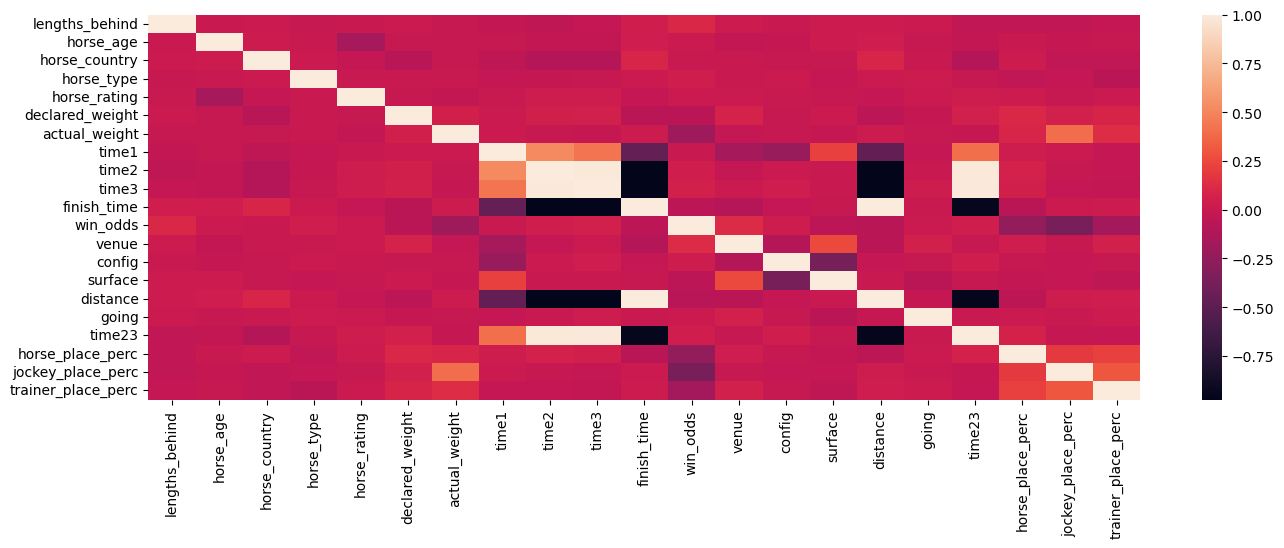

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,5))
sns.heatmap(df.corr())

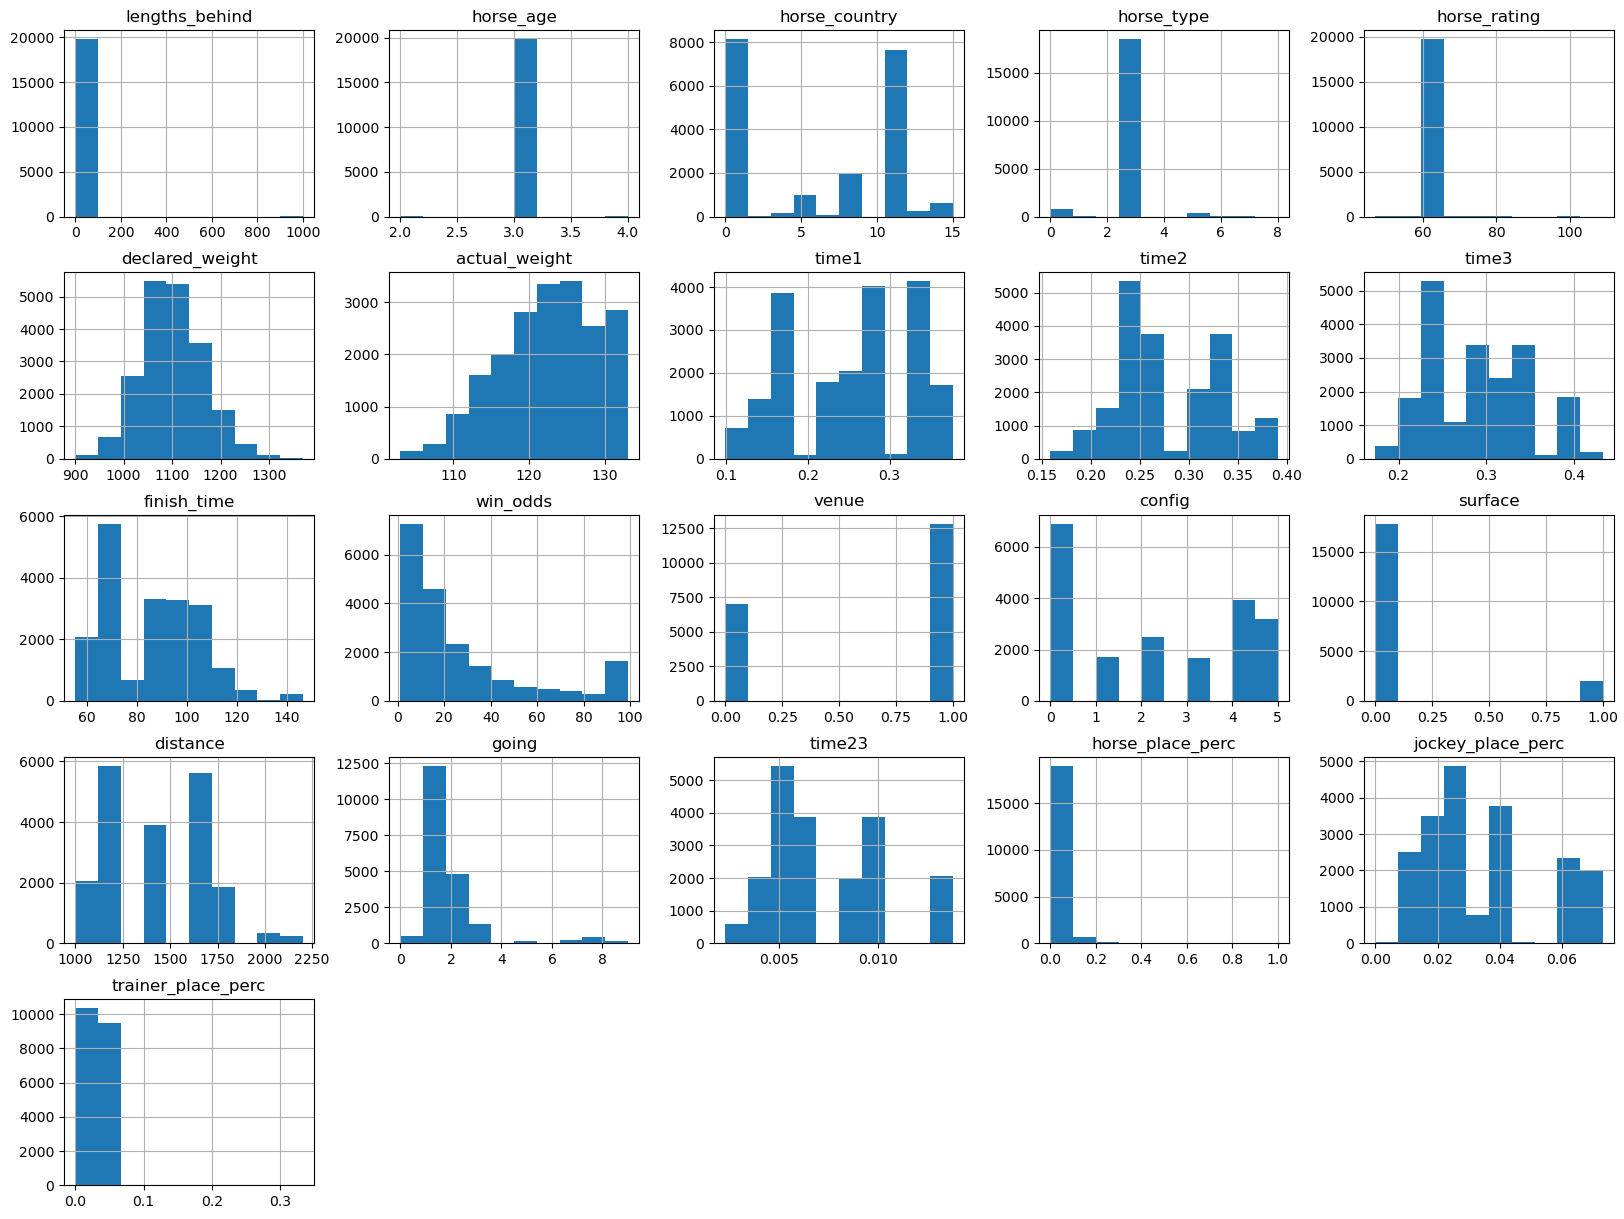

In [38]:
df.hist(figsize=(20, 15))
plt.show()

# Train Models

In [39]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression

In [40]:
# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [41]:
linearRegression = LinearRegression()
linearRegression.fit(x_train, y_train)

LinearRegression()

In [42]:
y_pred = linearRegression.predict(x_test)
y_pred

array([101.58838404,  97.15134169,  71.31838932, ...,  70.29016553,
        69.29039446,  71.54785809])

In [43]:
# Evaluating Model - Linear Regression
print(f"Linear Regression Results:")
print(f"Mean Squared Error:", mean_squared_error(y_test, y_pred))
print(f"Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print(f"R2 Score:", r2_score(y_test, y_pred))

Linear Regression Results:
Mean Squared Error: 1.091810885989944
Mean Absolute Error: 0.7556466619618493
R2 Score: 0.9965845445104808


### KNN

In [44]:
# KNN
from sklearn.neighbors import KNeighborsRegressor

In [45]:
knnRegression = KNeighborsRegressor(n_neighbors=5)
knnRegression.fit(x_train, y_train)

KNeighborsRegressor()

In [46]:
y_predKNN = knnRegression.predict(x_test)
y_predKNN

array([100.654,  96.778,  70.726, ...,  69.704,  69.31 ,  70.614])

In [47]:
# Evaluating Model - KNN
print(f"KNN Regression Results:")
print(f"Mean Squared Error:", mean_squared_error(y_test, y_predKNN))
print(f"Mean Absolute Error:", mean_absolute_error(y_test, y_predKNN))
print(f"R2 Score:", r2_score(y_test, y_predKNN))

KNN Regression Results:
Mean Squared Error: 4.047297439073515
Mean Absolute Error: 1.0345876132930512
R2 Score: 0.9873390488834823


### Decision Tree

In [48]:
# Decision Tree Regression
from sklearn.tree import DecisionTreeRegressor

In [49]:
treeRegression = DecisionTreeRegressor(max_depth=5, random_state=42)
treeRegression.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [50]:
# Evaluating Model - Decision Tree
y_predTree = treeRegression.predict(x_test)
y_predTree

array([101.64624708,  96.42169671,  69.90935294, ...,  71.20495255,
        69.90935294,  71.20495255])

In [51]:
print("Decision Tree Results:")
print(f"Mean Squared Error:", mean_squared_error(y_test, y_predTree))
print(f"Mean Absolute Error:", mean_absolute_error(y_test, y_predTree))
print(f"R2 Score:", r2_score(y_test, y_predTree))

Decision Tree Results:
Mean Squared Error: 0.7813076004909004
Mean Absolute Error: 0.6537017613863132
R2 Score: 0.9975558758688505


In [52]:
# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

In [53]:
# Decision Tree Regressor
parameterGridTree = {"max_depth": [3,5,10, None], 'min_samples_split': [2,5,10]}
gridTree = GridSearchCV(DecisionTreeRegressor(random_state=42), parameterGridTree, cv=5, scoring='neg_mean_squared_error')
gridTree.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [3, 5, 10, None],
                         'min_samples_split': [2, 5, 10]},
             scoring='neg_mean_squared_error')

In [54]:
print(f"Best Parameters for Decision Tree:", gridTree.best_params_)

Best Parameters for Decision Tree: {'max_depth': None, 'min_samples_split': 10}


In [55]:
# KNN Regressor
parameterGridKNN = {'n_neighbors': [3,5,7,10]}
gridKNN = GridSearchCV(KNeighborsRegressor(), parameterGridKNN, cv=5, scoring='neg_mean_squared_error')
gridKNN.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [3, 5, 7, 10]},
             scoring='neg_mean_squared_error')

In [56]:
print(f"Best Parameters for KNN:", gridKNN.best_params_)

Best Parameters for KNN: {'n_neighbors': 3}


### Random Forest Regressor

In [57]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators = 100, max_depth = 10)

rfr.fit(x_train, y_train)

y_pred = rfr.predict(x_test)

MAE: 0.2266082662756509
MSE: 0.13330559745331585
RMSE: 0.36511039077697566
R² Score: 0.9995829869985289


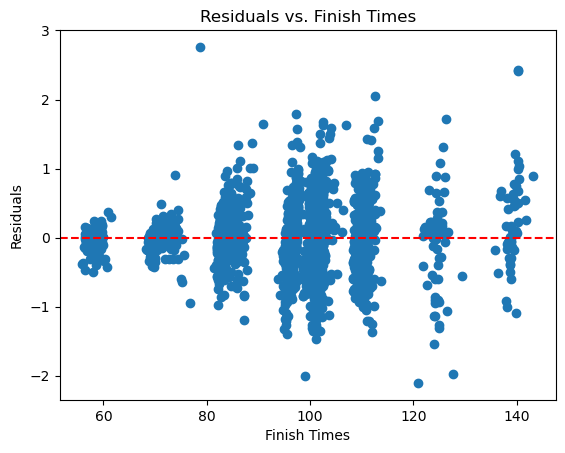

In [58]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def metrics(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"R² Score: {r2}")

metrics(y_test, y_pred)

residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Finish Times")
plt.ylabel("Residuals")
plt.title("Residuals vs. Finish Times")
plt.show()

### Bagging Regressor

MAE: 0.14772346424974905
MSE: 0.07651330735146081
RMSE: 0.2766103890880833
R² Score: 0.9997606473804501


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fi

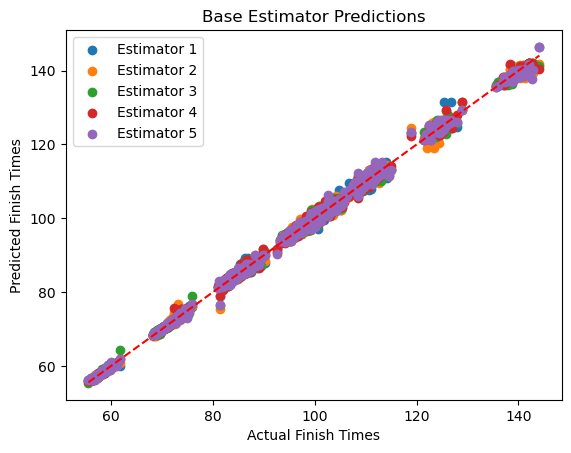

In [59]:
from sklearn.ensemble import BaggingRegressor

br = BaggingRegressor(estimator=None, n_estimators = 50, max_samples = .8,bootstrap = True)

br.fit(x_train, y_train)

y_pred = br.predict(x_test)

metrics(y_test, y_pred)

base_preds = [estimator.predict(x_test) for estimator in br.estimators_]
for i, pred in enumerate(base_preds[:5]):
    plt.scatter(y_test, pred, label=f"Estimator {i+1}")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.legend()
plt.xlabel("Actual Finish Times")
plt.ylabel("Predicted Finish Times")
plt.title("Base Estimator Predictions")
plt.show()

### AdaBoost Regressor

MAE: 1.0033166133445621
MSE: 1.5332336351221072
RMSE: 1.2382381172949357
R² Score: 0.9952036645695788


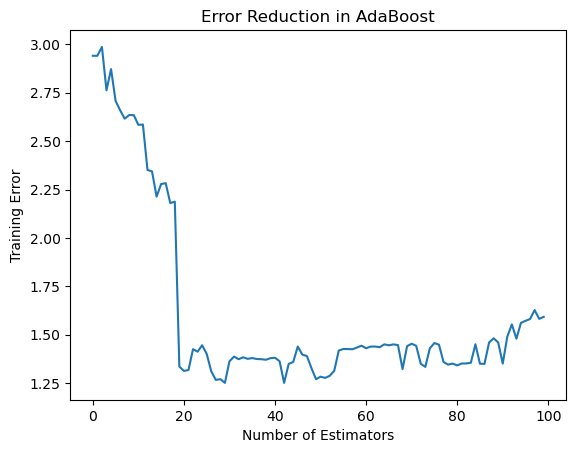

In [60]:
from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor(estimator=None, n_estimators = 100, learning_rate = 1)

ada.fit(x_train, y_train)

y_pred = ada.predict(x_test)

metrics(y_test, y_pred)

train_errors = []
for pred in ada.staged_predict(x_train):
    train_errors.append(mean_squared_error(y_train, pred))
plt.plot(range(len(train_errors)), train_errors)
plt.xlabel("Number of Estimators")
plt.ylabel("Training Error")
plt.title("Error Reduction in AdaBoost")
plt.show()

### Stacking Regressor

MAE: 0.2424987805828359
MSE: 0.16855863416097974
RMSE: 0.41055892897485463
R² Score: 0.9994727067482672


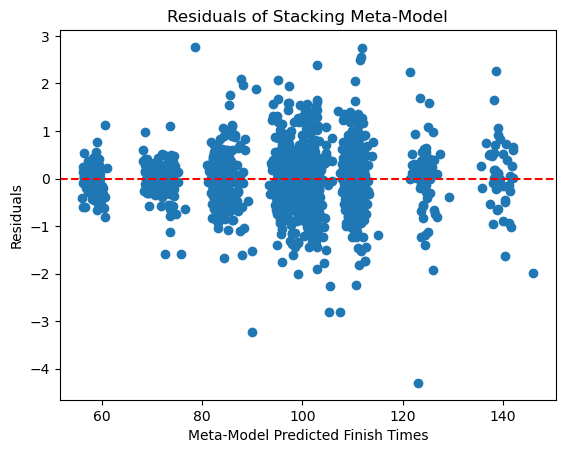

In [61]:
from sklearn.ensemble import StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression

st = StackingRegressor(estimators=[('decision_tree', DecisionTreeRegressor()),('knn', KNeighborsRegressor())])

st.fit(x_train, y_train)

y_pred = st.predict(x_test)

metrics(y_test, y_pred)

base_preds = [st.named_estimators_[name].predict(x_test) for name in st.named_estimators_]
meta_preds = st.final_estimator_.predict(np.column_stack(base_preds))

residuals_meta = y_test - meta_preds
plt.scatter(meta_preds, residuals_meta)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Meta-Model Predicted Finish Times")
plt.ylabel("Residuals")
plt.title("Residuals of Stacking Meta-Model")
plt.show()

### SVR

Support Vector Regression

In [62]:
from sklearn.svm import SVR

C = 10

In [63]:
svr_rbf = SVR(kernel="rbf", C=C, epsilon=0.01).fit(x_train, y_train)
y_pred_rbf = svr_rbf.predict(x_test)
print("SVR RBF Results:")
print(f"Mean Squared Error:", mean_squared_error(y_test, y_pred_rbf))
print(f"Mean Absolute Error:", mean_absolute_error(y_test, y_pred_rbf))
print(f"R2 Score:", r2_score(y_test, y_pred_rbf))

SVR RBF Results:
Mean Squared Error: 1.687394790894504
Mean Absolute Error: 0.40534179468710396
R2 Score: 0.9947214102043678


In [65]:
svr_poly = SVR(kernel="poly", C=C, gamma="scale").fit(x_train, y_train)
y_pred_poly = svr_poly.predict(x_test)
print("SVR Polynomial Results:")
print(f"Mean Squared Error:", mean_squared_error(y_test, y_pred_poly))
print(f"Mean Absolute Error:", mean_absolute_error(y_test, y_pred_poly))
print(f"R2 Score:", r2_score(y_test, y_pred_poly))

SVR Polynomial Results:
Mean Squared Error: 5.741060891719794
Mean Absolute Error: 1.0522152855535702
R2 Score: 0.9820405363328931


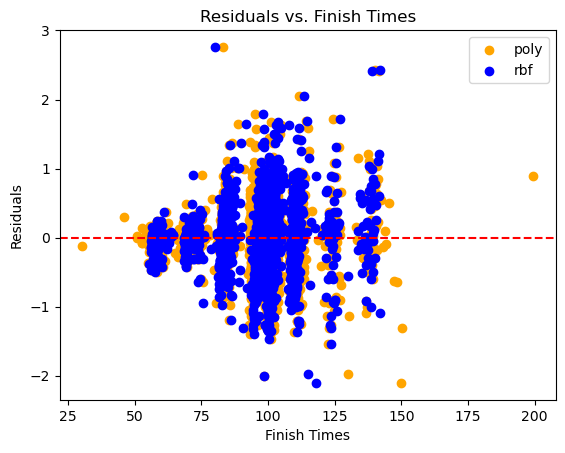

In [72]:
residuals_rbf = y_test - y_pred_rbf
residuals_rbf = y_test - y_pred_poly
plt.scatter(y_pred_poly, residuals, color='orange', label='poly')
plt.scatter(y_pred_rbf, residuals, color='blue', label='rbf')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Finish Times")
plt.ylabel("Residuals")
plt.title("Residuals vs. Finish Times")
plt.legend()
plt.show()

In [ ]:
residuals_rbf = y_test - y_pred_poly
plt.scatter(y_pred_poly, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Finish Times")
plt.ylabel("Residuals")
plt.title("Residuals vs. Finish Times")
plt.show()

### Neural Networks


In [129]:
#import libraries
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [130]:
#creating the deep residual network
def deepResidualNetwork(input_shape):
    model = Sequential([
        #decided to use elu = exponential linear unit for activation function
        #first layer--> has 256 neurons
        Dense(256, activation='elu', input_shape=(input_shape,)),
        BatchNormalization(),
        #dropout was picked to be moderate--> this is based on studies of NNs
        Dropout(0.3),
        #second layer--> has 128 neurons
        Dense(128, activation='elu'),
        BatchNormalization(),
        Dropout(0.3),
        #thrid layer--> has 64 neurons
        Dense(64, activation='elu'),
        BatchNormalization(),
        #fourth layer--> has 32 neurons
        Dense(32, activation='elu'),
        #output layer--> 1 neuron for finish time
        Dense(1)
    ])
    #using adam optimizer and a small alpha, 
    #for loss we are using huber--> it is more prone to outlier adaptation than MSE
    model.compile(optimizer=Adam(learning_rate=0.01), loss='huber')
    return model

In [131]:

#creating the pyramid neural network 
def pyramidNeuralNetwork(input_shape):
    model = Sequential([
        #first layer--> base of pyramid with 512 neurons
        Dense(512, activation='selu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.4),
        #second layer--> half the neurons = 256 neurons
        Dense(256, activation='selu'),
        BatchNormalization(),
        Dropout(0.3),
        #third layer--> half neurons again 
        Dense(128, activation='selu'),
        BatchNormalization(),
        Dropout(0.2),
        #fourth layer --> half neurons
        Dense(64, activation='selu'),
        BatchNormalization(),
        #fifth layer--> half nuerons
        Dense(32, activation='selu'),
        #output= pyramid top
        Dense(1)
    ])
    #using adam optimizer with a 0.01 alpha and the huber loss
    model.compile(optimizer=Adam(learning_rate=0.01), loss='huber')
    return model

In [132]:
def simpleNeuralNetwork(input_shape):
    model = Sequential([
        # a single layer that directly maps inputs to output
        Dense(1, input_shape=(input_shape,))
    ])
    #also using adam and huber
    model.compile(optimizer=Adam(learning_rate=0.01), loss='huber')
    return model

In [133]:
def get_callbacks(): #monitoring val loss to earling stop or update learning rate 
    return [
        #we are monitoring the val_loss
        #val loss is a metric that calculates how well the model will perform on unseen data
        EarlyStopping( #stop early if neccesary
            monitor='val_loss',
            patience=10, #waits 10 epochs for improvement
            restore_best_weights=True #we want to keep the weaits that give the best val loss
        ),
        ReduceLROnPlateau( #we will reduce learning rate when we see it plateau on performance
            monitor='val_loss', #monitoring val loss to see if LR needs adjustment 
            factor=0.5, #multiplies learning rate if need be
            patience=10, #waits 10 epochs
            min_lr=0.0001 #set a lower bound 
        )
    ]


In [134]:
#training and evaluating the model
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name): 
    callbacks = get_callbacks()
    history = model.fit(
        X_train, y_train, #splitting x training and y training
        validation_split=0.2, #takes 20 percent of trainng data for validation
        epochs=100, #using 100 epochs 
        batch_size=32, #number of samples that we process before model updates
        callbacks=callbacks,#may want to correct model during training
        verbose=1 #print what is happening
    )
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred) #calculates MSE between predicted and actual
    r2 = r2_score(y_test, y_pred)# calculates coeff of determination
    return history, mse, r2, y_pred

In [135]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Create testing samples to test the Neural Networks 
test_races = pd.concat([test_1, test_2, test_3, test_4, test_5]) #all races we are testing 
X_test_nn = test_races.drop(['race_id', 'result', 'finish_time'], axis=1) #remove columns not needed 
X_test_nn = pd.DataFrame(scaler.fit_transform(X_test_nn), columns=X_test_nn.columns) #x test set
y_test_nn = test_races['finish_time'] #y test set

#all models that we run on test data
models = {
    'Simple NN': simpleNeuralNetwork(X.shape[1]), #Regular NN
    'Deep Residual NN': deepResidualNetwork(X.shape[1]), #deep residual NN
    'Pyramid NN': pyramidNeuralNetwork(X.shape[1]), #pyramid NN
}
results = {} #store training results 
predictions = {} #store model predictions

# train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    history, mse, r2, y_pred = evaluate_model(
        model, 
        x_train, 
        y_train, 
        X_test_nn, 
        y_test_nn, 
        name
    )
    results[name] = {
        'history': history,
        'mse': mse,
        'r2': r2
    }
    predictions[name] = y_pred.flatten()


f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Simple NN...
Epoch 1/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 84.3218 - val_loss: 81.1882 - learning_rate: 0.0100
Epoch 2/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 80.1628 - val_loss: 77.2469 - learning_rate: 0.0100
Epoch 3/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 76.4579 - val_loss: 73.3089 - learning_rate: 0.0100
Epoch 4/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 72.2061 - val_loss: 69.3688 - learning_rate: 0.0100
Epoch 5/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 68.3356 - val_loss: 65.4267 - learning_rate: 0.0100
Epoch 6/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 64.2234 - val_loss: 61.4952 - learning_rate: 0.0100
Epoch 7/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 60.2148 - val_loss: 57.5598 - learning_rate: 0.0100
Epoch 8/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 56.1972 - val_loss: 53.6239 - learning_rate: 0.0100
Epoch 9/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 52.2998 - va

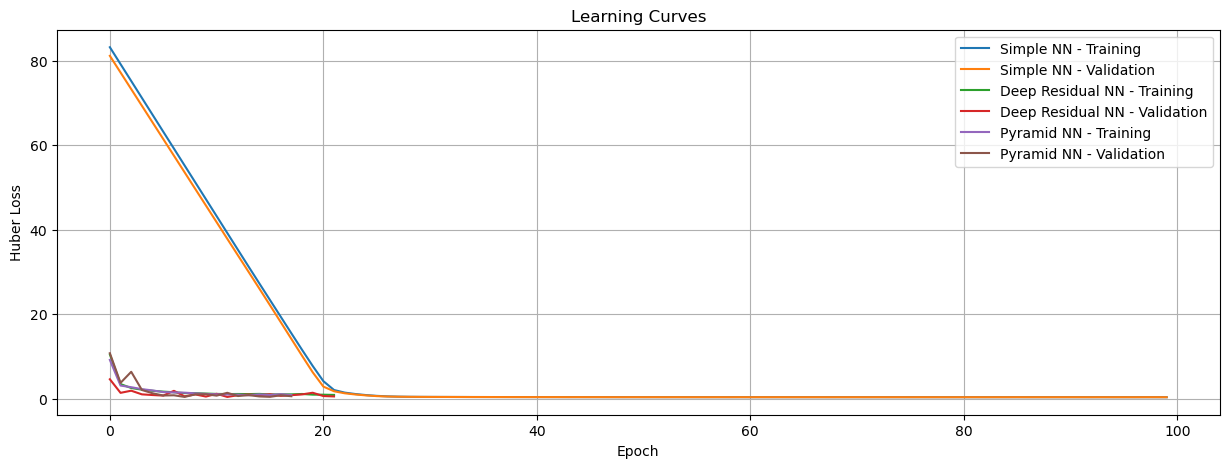

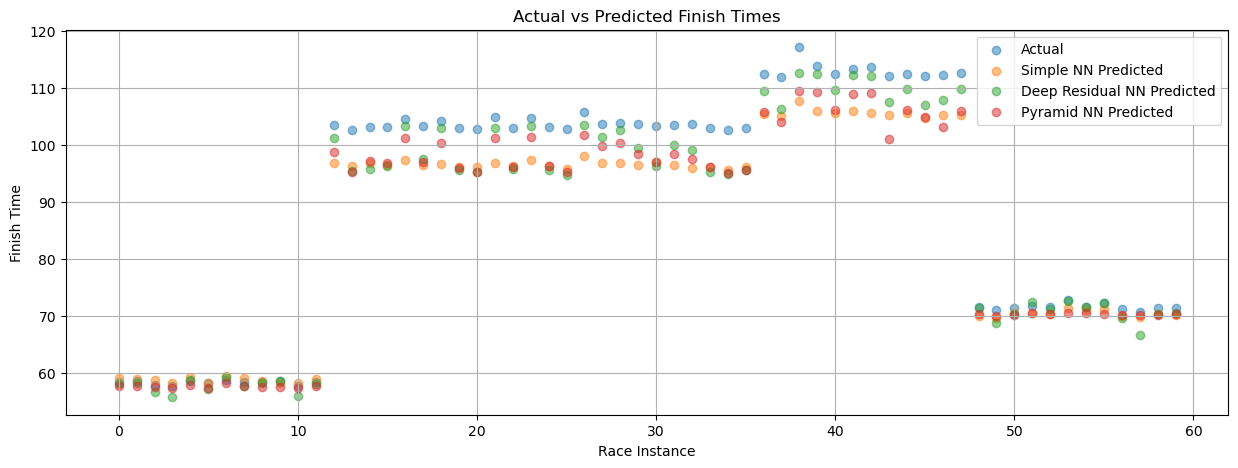


Model Performance Metrics:
--------------------------------------------------

Simple NN:
Mean Squared Error: 31.1053
Root Mean Squared Error: 5.5772
R² Score: 0.9306

Deep Residual NN:
Mean Squared Error: 16.1061
Root Mean Squared Error: 4.0132
R² Score: 0.9641

Pyramid NN:
Mean Squared Error: 24.4934
Root Mean Squared Error: 4.9491
R² Score: 0.9454

Best performing model was Deep Residual NN


In [136]:
#all visualization functions
#learning curve to watch alpha change 
def learningCurve():
    plt.figure(figsize=(15, 5))
    for name, result in results.items():
        plt.plot(result['history'].history['loss'], label=f'{name} - Training')
        plt.plot(result['history'].history['val_loss'], label=f'{name} - Validation')
    plt.title('Learning Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Huber Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
#a scatter plot to see how well each model performs 
def modelPredictions():
    plt.figure(figsize=(15, 5))
    plt.scatter(range(len(y_test_nn)), y_test_nn, label='Actual', alpha=0.5)
    for name, pred in predictions.items():
        plt.scatter(range(len(pred)), pred, label=f'{name} Predicted', alpha=0.5)
    plt.title('Actual vs Predicted Finish Times')
    plt.xlabel('Race Instance')
    plt.ylabel('Finish Time')
    plt.legend()
    plt.grid(True)
    plt.show()
#print results of the models 
def performanceMetrics():
    print("\nModel Performance Metrics:")
    print("-" * 50)
    for name, result in results.items():
        print(f"\n{name}:")
        print(f"Mean Squared Error: {result['mse']:.4f}")
        print(f"Root Mean Squared Error: {np.sqrt(result['mse']):.4f}")
        print(f"R² Score: {result['r2']:.4f}")
learningCurve()
modelPredictions()
performanceMetrics()

#show best model
best_model_name = min(results, key=lambda x: results[x]['mse'])
best_model = models[best_model_name]
print(f"\nBest performing model was {best_model_name}")

# Test Models Against New Races

Now that we have trained multiple models, we will compare them by testing them against the 5 test races we extracted earlier

In [137]:
test_races = [data[data.race_id == race_id].copy() for race_id in [1601, 1602, 1603, 1604, 1605]] # use this notation instead of [test_1, etc] to avoid warnings

lin_preds = []  

knn_preds = []

tree_preds = []

rf_preds = []

bag_preds = []

ada_preds = []

stack_preds = []

svr_preds = []

nn_preds = []

for race in test_races:
    X = race.drop(["finish_time", "result", "race_id"], axis=1)
    X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

    lin_preds.append(linearRegression.predict(X))

    knn_preds.append(knnRegression.predict(X))

    tree_preds.append(treeRegression.predict(X))

    rf_preds.append(rfr.predict(X))

    bag_preds.append(br.predict(X))

    ada_preds.append(ada.predict(X))

    stack_preds.append(st.predict(X))

    svr_preds.append(svr_rbf.predict(X))

    nn_preds.append(models['Deep Residual NN'].predict(X))

    # add new columns with nn predictions here
    # nn_preds.append(nn.predict(race)) 


for i, race in enumerate(test_races):
    race["linear_pred"] = knn_preds[i]
    race["linear_result"] = race["linear_pred"].rank(ascending=True).astype(int)

    race["knn_pred"] = knn_preds[i]
    race["knn_result"] = race["knn_pred"].rank(ascending=True).astype(int)

    race["tree_pred"] = tree_preds[i]
    race["tree_result"] = race["tree_pred"].rank(ascending=True).astype(int)

    race["rf_pred"] = tree_preds[i]
    race["rf_result"] = race["rf_pred"].rank(ascending=True).astype(int)

    race["bagging_pred"] = tree_preds[i]
    race["bagging_result"] = race["bagging_pred"].rank(ascending=True).astype(int)

    race["ada_pred"] = tree_preds[i]
    race["ada_result"] = race["ada_pred"].rank(ascending=True).astype(int)

    race["stack_pred"] = tree_preds[i]
    race["stack_result"] = race["stack_pred"].rank(ascending=True).astype(int)

    race["svr_pred"] = svr_preds[i]
    race["svr_result"] = race["svr_pred"].rank(ascending=True).astype(int)

    race["nn_pred"] = nn_preds[i].flatten()
    race["nn_result"] = race["nn_pred"].rank(ascending=True).astype(int)

    # add new columns with nn predictions here
    # test_races[i]["nn_pred"] = nn_preds[i]
    # test_races[i]["nn_result"] = test_races[i]["nn_result"].rank(ascending=True).astype(int)

    # make sure to add your columns to this list
    test_races[i] = race[['finish_time', 'result', 
                          'linear_pred', 'linear_result',
                          'knn_pred', 'knn_result',
                          'tree_pred', 'tree_result',
                          'knn_pred', 'knn_result',
                          'rf_pred', 'rf_result',
                          'bagging_pred', 'bagging_result',
                          'ada_pred', 'ada_result',
                          'stack_pred', 'stack_result',
                          'svr_pred', 'svr_result', 'nn_pred', 'nn_result']]





1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [138]:
test_races[0]

,finish_time,result,linear_pred,linear_result,knn_pred,knn_result,tree_pred,tree_result,knn_pred,knn_result,...,bagging_pred,bagging_result,ada_pred,ada_result,stack_pred,stack_result,svr_pred,svr_result,nn_pred,nn_result
20052,58.43,6,83.118,4,83.118,4,82.333190,3,83.118,4,...,82.333190,3,82.333190,3,82.333190,3,69.500491,4,82.484756,5
20053,58.52,9,78.772,1,78.772,1,90.246842,8,78.772,1,...,90.246842,8,90.246842,8,90.246842,8,99.437490,8,98.363243,9
20054,57.93,3,83.764,7,83.764,7,82.333190,3,83.764,7,...,82.333190,3,82.333190,3,82.333190,3,53.356093,3,71.341759,3
20055,57.63,1,82.970,3,82.970,3,82.333190,3,82.970,3,...,82.333190,3,82.333190,3,82.333190,3,48.621009,2,53.543884,1
20056,58.63,10,86.884,8,86.884,8,90.246842,8,86.884,8,...,90.246842,8,90.246842,8,90.246842,8,99.792627,9,93.265152,8
20057,58.21,4,82.872,2,82.872,2,82.333190,3,82.872,2,...,82.333190,3,82.333190,3,82.333190,3,72.374263,5,79.874809,4
20058,58.79,12,96.568,11,96.568,11,112.749310,12,96.568,11,...,112.749310,12,112.749310,12,112.749310,12,116.247497,12,103.525513,12
20059,58.35,5,92.162,9,92.162,9,83.556640,7,92.162,9,...,83.556640,7,83.556640,7,83.556640,7,84.647882,7,86.856468,7
20060,58.49,8,83.442,6,83.442,6,82.333190,3,83.442,6,...,82.333190,3,82.333190,3,82.333190,3,82.462727,6,84.396530,6
20061,58.67,11,96.134,10,96.134,10,111.039468,10,96.134,10,...,111.039468,10,111.039468,10,111.039468,10,107.350030,11,102.639687,11


In [139]:
test_races[1]

,finish_time,result,linear_pred,linear_result,knn_pred,knn_result,tree_pred,tree_result,knn_pred,knn_result,...,bagging_pred,bagging_result,ada_pred,ada_result,stack_pred,stack_result,svr_pred,svr_result,nn_pred,nn_result
20064,103.52,8,88.326,8,88.326,8,82.333190,6,88.326,8,...,82.333190,6,82.333190,6,82.333190,6,79.493886,8,81.570724,7
20065,102.61,1,57.286,1,57.286,1,69.909353,1,57.286,1,...,69.909353,1,69.909353,1,69.909353,1,63.697569,1,55.392063,1
20066,103.20,6,94.602,9,94.602,9,82.333190,6,94.602,9,...,82.333190,6,82.333190,6,82.333190,6,75.680733,7,99.052399,10
20067,103.18,5,83.602,6,83.602,6,73.003699,3,83.602,6,...,73.003699,3,73.003699,3,73.003699,3,71.345484,5,75.045532,4
20068,104.53,10,84.618,7,84.618,7,105.544444,10,84.618,7,...,105.544444,10,105.544444,10,105.544444,10,108.607307,11,89.685616,8
20069,103.32,7,83.330,5,83.330,5,82.333190,6,83.330,5,...,82.333190,6,82.333190,6,82.333190,6,73.904556,6,80.395935,6
20070,104.12,9,95.856,10,95.856,10,100.398167,9,95.856,10,...,100.398167,9,100.398167,9,100.398167,9,96.952407,9,96.189789,9
20071,102.95,3,70.590,4,70.590,4,82.333190,6,70.590,4,...,82.333190,6,82.333190,6,82.333190,6,66.026780,3,76.015915,5
20072,102.79,2,67.622,2,67.622,2,69.909353,1,67.622,2,...,69.909353,1,69.909353,1,69.909353,1,65.910399,2,58.956795,2
20073,104.88,12,111.418,12,111.418,12,142.083333,12,111.418,12,...,142.083333,12,142.083333,12,142.083333,12,113.293228,12,111.301422,12


In [140]:
test_races[2]

,finish_time,result,linear_pred,linear_result,knn_pred,knn_result,tree_pred,tree_result,knn_pred,knn_result,...,bagging_pred,bagging_result,ada_pred,ada_result,stack_pred,stack_result,svr_pred,svr_result,nn_pred,nn_result
20076,103.06,5,83.646,8,83.646,8,82.333190,6,83.646,8,...,82.333190,6,82.333190,6,82.333190,6,73.481892,5,79.362259,6
20077,102.75,2,69.824,2,69.824,2,73.003699,4,69.824,2,...,73.003699,4,73.003699,4,73.003699,4,62.576950,2,69.263184,3
20078,105.71,12,112.726,12,112.726,12,142.083333,12,112.726,12,...,142.083333,12,142.083333,12,142.083333,12,113.548244,12,112.759140,12
20079,103.65,10,96.568,10,96.568,10,84.027953,9,96.568,10,...,84.027953,9,84.027953,9,84.027953,9,84.287318,9,96.907585,9
20080,103.79,11,83.496,7,83.496,7,84.027953,9,83.496,7,...,84.027953,9,84.027953,9,84.027953,9,86.992869,10,85.703819,8
20081,103.63,9,95.904,9,95.904,9,83.059286,8,95.904,9,...,83.059286,8,83.059286,8,83.059286,8,83.073869,8,98.991257,10
20082,103.30,6,76.030,5,76.030,5,73.003699,4,76.030,5,...,73.003699,4,73.003699,4,73.003699,4,74.136194,6,77.257942,5
20083,103.54,7,97.510,11,97.510,11,100.398167,11,97.510,11,...,100.398167,11,100.398167,11,100.398167,11,92.830232,11,100.516357,11
20084,103.63,8,82.844,6,82.844,6,73.003699,4,82.844,6,...,73.003699,4,73.003699,4,73.003699,4,80.442018,7,83.792183,7
20085,102.88,4,70.576,4,70.576,4,82.333190,6,70.576,4,...,82.333190,6,82.333190,6,82.333190,6,66.661168,3,72.906860,4


In [141]:
test_races[3]

,finish_time,result,linear_pred,linear_result,knn_pred,knn_result,tree_pred,tree_result,knn_pred,knn_result,...,bagging_pred,bagging_result,ada_pred,ada_result,stack_pred,stack_result,svr_pred,svr_result,nn_pred,nn_result
20088,112.39,5,83.254,8,83.254,8,82.333190,7,83.254,8,...,82.333190,7,82.333190,7,82.333190,7,70.788841,5,80.828003,8
20089,111.97,1,82.868,6,82.868,6,69.909353,1,82.868,6,...,69.909353,1,69.909353,1,69.909353,1,66.882061,1,63.146866,1
20090,117.12,12,111.520,12,111.520,12,139.563363,12,111.520,12,...,139.563363,12,139.563363,12,139.563363,12,112.413237,12,116.049988,12
20091,113.86,11,95.644,10,95.644,10,96.421697,10,95.644,10,...,96.421697,10,96.421697,10,96.421697,10,95.740780,11,103.114410,11
20092,112.47,6,76.710,3,76.710,3,82.333190,7,76.710,3,...,82.333190,7,82.333190,7,82.333190,7,71.646333,6,76.734024,5
20093,113.25,9,91.112,9,91.112,9,82.333190,7,91.112,9,...,82.333190,7,82.333190,7,82.333190,7,83.423658,9,82.762878,9
20094,113.65,10,96.226,11,96.226,11,96.421697,10,96.226,11,...,96.421697,10,96.421697,10,96.421697,10,90.845043,10,102.007217,10
20095,112.09,2,82.914,7,82.914,7,82.333190,7,82.914,7,...,82.333190,7,82.333190,7,82.333190,7,68.638410,2,78.451736,6
20096,112.49,7,70.800,2,70.800,2,73.003699,3,70.800,2,...,73.003699,3,73.003699,3,73.003699,3,72.959328,7,73.721802,3
20097,112.14,3,82.724,5,82.724,5,82.333190,7,82.724,5,...,82.333190,7,82.333190,7,82.333190,7,69.103685,3,74.195816,4


In [142]:
test_races[4]

,finish_time,result,linear_pred,linear_result,knn_pred,knn_result,tree_pred,tree_result,knn_pred,knn_result,...,bagging_pred,bagging_result,ada_pred,ada_result,stack_pred,stack_result,svr_pred,svr_result,nn_pred,nn_result
20100,71.56,9,97.170,12,97.170,12,96.421697,8,97.170,12,...,96.421697,8,96.421697,8,96.421697,8,96.162841,8,100.869972,11
20101,71.06,2,75.378,2,75.378,2,73.003699,2,75.378,2,...,73.003699,2,73.003699,2,73.003699,2,63.387107,3,71.258209,2
20102,71.37,4,83.642,6,83.642,6,82.333190,5,83.642,6,...,82.333190,5,82.333190,5,82.333190,5,55.004155,2,71.377251,3
20103,71.81,10,83.944,7,83.944,7,82.333190,5,83.944,7,...,82.333190,5,82.333190,5,82.333190,5,85.634456,7,84.636108,7
20104,71.53,7,96.374,9,96.374,9,112.749310,11,96.374,9,...,112.749310,11,112.749310,11,112.749310,11,102.730279,12,98.700600,10
20105,72.81,12,83.582,4,83.582,4,96.421697,8,83.582,4,...,96.421697,8,96.421697,8,96.421697,8,98.788596,10,85.973511,8
20106,71.56,8,84.016,8,84.016,8,82.333190,5,84.016,8,...,82.333190,5,82.333190,5,82.333190,5,71.737234,5,81.250557,5
20107,72.26,11,97.136,11,97.136,11,105.544444,10,97.136,11,...,105.544444,10,105.544444,10,105.544444,10,98.502228,9,102.387695,12
20108,71.25,3,80.618,3,80.618,3,73.003699,2,80.618,3,...,73.003699,2,73.003699,2,73.003699,2,74.722465,6,77.241737,4
20109,70.61,1,67.740,1,67.740,1,69.909353,1,67.740,1,...,69.909353,1,69.909353,1,69.909353,1,46.618805,1,54.217068,1


## Data visualization and Model Comparision


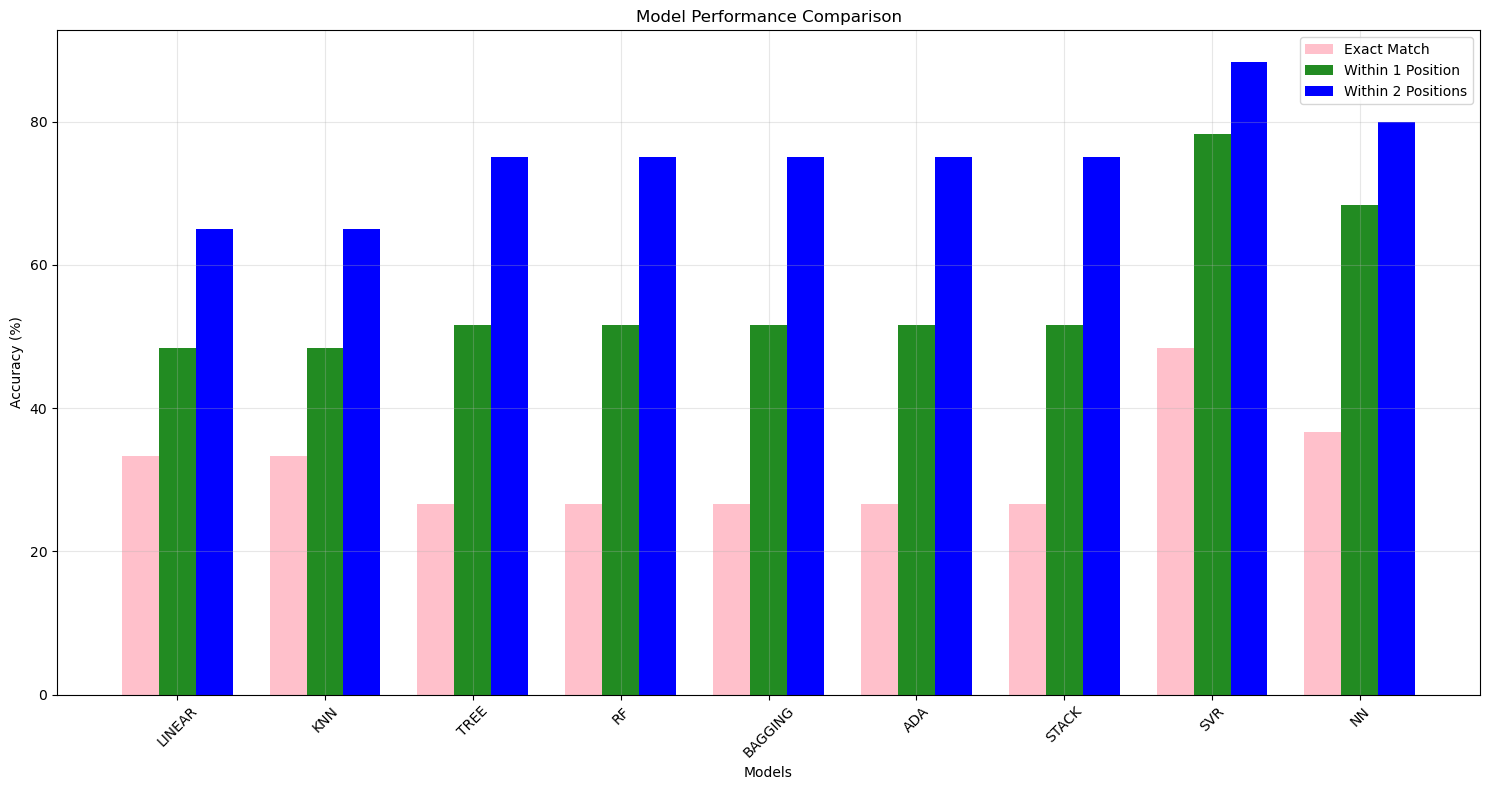


Model Performance Summary:
--------------------------------------------------------------------------------
  Model  Exact Match (%)  Within 1 Position (%)  Within 2 Positions (%)
    svr            48.33                  78.33                   88.33
     nn            36.67                  68.33                   80.00
 linear            33.33                  48.33                   65.00
    knn            33.33                  48.33                   65.00
   tree            26.67                  51.67                   75.00
     rf            26.67                  51.67                   75.00
bagging            26.67                  51.67                   75.00
    ada            26.67                  51.67                   75.00
  stack            26.67                  51.67                   75.00

Best Performing Model: SVR
Exact Match Accuracy: 48.33%
Within 1 Position Accuracy: 78.33%
Within 2 Positions Accuracy: 88.33%


In [143]:
# we want to compare and calculate overal model accuracy 
def calculate_accuracy(actual, predicted):
    if isinstance(predicted, pd.DataFrame):
        predicted = predicted.iloc[:, 0]  # we want first column if it s a DF
    actual = actual.values
    predicted = predicted.values
    #math metrics for calculations 
    exact_matches = (actual == predicted).mean() * 100
    within_one = (abs(actual - predicted) <= 1).mean() * 100
    within_two = (abs(actual - predicted) <= 2).mean() * 100
    return exact_matches, within_one, within_two

#a list for the results 
models = ['linear', 'knn', 'tree', 'rf', 'bagging', 'ada', 'stack', 'svr', 'nn']
exact_accuracies = []
within_one_accuracies = []
within_two_accuracies = []

#loop through and retrieve accuracies 
for model in models:
    exact_total = 0
    within_one_total = 0
    within_two_total = 0  
    for race in test_races:
        actual = race['result']
        
        # knn had duplicates
        if model == 'knn':
            predicted = race['knn_result'].iloc[:, 0]
        else:
            predicted = race[f'{model}_result']
        exact, one, two = calculate_accuracy(actual, predicted)
        exact_total += exact
        within_one_total += one
        within_two_total += two
    
    #want to average these reults 
    exact_accuracies.append(exact_total / len(test_races))
    within_one_accuracies.append(within_one_total / len(test_races))
    within_two_accuracies.append(within_two_total / len(test_races))

#a bar graph that will show model performance
plt.figure(figsize=(15, 8))
x = np.arange(len(models))
width = 0.25
#exact match means the model predicted exactly the position of the horse 
#within one shows the percentage of times that the model made a prediction within 1 of actual finish time 
#within two means it predicted within two positions of actual finish time 
plt.bar(x - width, exact_accuracies, width, label='Exact Match', color='pink')
plt.bar(x, within_one_accuracies, width, label='Within 1 Position', color='#228B22')
plt.bar(x + width, within_two_accuracies, width, label='Within 2 Positions', color='blue')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Model Performance Comparison')
plt.xticks(x, [m.upper() for m in models], rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#summary DF of our results so that we cna print them 
results_df = pd.DataFrame({
    'Model': models,
    'Exact Match (%)': exact_accuracies,
    'Within 1 Position (%)': within_one_accuracies,
    'Within 2 Positions (%)': within_two_accuracies
})

# sort by accuracy so that we can get the best model for race predictions 
results_df = results_df.sort_values('Exact Match (%)', ascending=False)

print("\nModel Performance Summary:")
print("-" * 80)
print(results_df.round(2).to_string(index=False))

#we want to find and display the best model 
best_model = results_df.iloc[0]['Model']
best_exact = results_df.iloc[0]['Exact Match (%)']
best_within_one = results_df.iloc[0]['Within 1 Position (%)']
best_within_two = results_df.iloc[0]['Within 2 Positions (%)']

print(f"\nBest Performing Model: {best_model.upper()}")
print(f"Exact Match Accuracy: {best_exact:.2f}%")
print(f"Within 1 Position Accuracy: {best_within_one:.2f}%")
print(f"Within 2 Positions Accuracy: {best_within_two:.2f}%")